# Circle approximation in LP by lazy constraints

_Combinatorial Optimization course, FEE CTU in Prague. Created by [Industrial Informatics Department](http://industrialinformatics.fel.cvut.cz)._

In [1]:
!pip install gurobipy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from typing import Tuple, List

import numpy as np
import gurobipy as g
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle
from matplotlib.widgets import Button
import math
import scipy.spatial


class Instance:

    __slots__ = ['circle_center', 'circle_radius', 'obj_coeffs']

    def __init__(self,
                 circle_center: Tuple[float, float],
                 circle_radius: float,
                 obj_coeffs: Tuple[float, float]):
        self.circle_center = circle_center
        self.circle_radius = circle_radius
        self.obj_coeffs = obj_coeffs


class Halfspace:

    __slots__ = ['xcoeff', 'ycoeff', 'b']

    def __init__(self, xcoeff: float, ycoeff: float, b: float):
        """
        Halfspace in form

        xcoeff * x + ycoeff * y <= b
        """
        self.xcoeff = xcoeff
        self.ycoeff = ycoeff
        self.b = b

    def to_scipy_halfspace(self) -> Tuple[float, float, float]:
        return (self.xcoeff, self.ycoeff, -self.b)


class Line:

    __slots__ = ['base_point', 'vector']

    def __init__(self, base_point: Tuple[float, float], vector: Tuple[float, float]):
        """
        Parametric equation of a line

        point = base_point + t * vector

        where t is a parameter.
        """
        self.base_point = base_point
        self.vector = normalize_vector(vector)

    def compute_point(self, t):
        return [self.base_point[0] + t * self.vector[0],
                self.base_point[1] + t * self.vector[1]]

    def to_halfspace(self, interior_point: Tuple[float, float]) -> Halfspace:
        coeffs = (self.vector[1], -self.vector[0])
        b = self.base_point[0] * self.vector[1] - self.base_point[1] * self.vector[0]
        if (interior_point[0] * coeffs[0] + interior_point[1] * coeffs[1]) > b:
            b = -b
            coeffs = [-coeff for coeff in coeffs]

        return Halfspace(coeffs[0], coeffs[1], b)

    @staticmethod
    def create_tangent_line(ins: Instance, solution: Tuple[float, float]) -> 'Line':
        vector = normalize_vector([solution[0] - ins.circle_center[0],
                                   solution[1] - ins.circle_center[1]])
        base_point = Line(ins.circle_center, vector).compute_point(ins.circle_radius)
        return Line(base_point, [vector[1], -vector[0]])


def compute_vector_length(vector):
    return math.sqrt(1.0 * (vector[0]**2 + vector[1]**2))

def normalize_vector(vector):
    length = compute_vector_length(vector)
    return [vector[0] / length, vector[1] / length]


def solve_model(ins: Instance, rectangle_lines: List[Line], tangent_lines: List[Line]):
    m = g.Model("circle")
    m.Params.OutputFlag = 0

    x = m.addVar(lb=-g.GRB.INFINITY, ub=g.GRB.INFINITY, vtype=g.GRB.CONTINUOUS)
    y = m.addVar(lb=-g.GRB.INFINITY, ub=g.GRB.INFINITY, vtype=g.GRB.CONTINUOUS)

    m.update()

    # Generate halfspaces and constraints from them.
    for tangent_line in rectangle_lines + tangent_lines:
        halfspace = tangent_line.to_halfspace(ins.circle_center)
        m.addConstr(x * halfspace.xcoeff + y * halfspace.ycoeff <= halfspace.b)

    m.setObjective(x * ins.obj_coeffs[0] + y * ins.obj_coeffs[1])

    m.optimize()

    return [x.X, y.X]


def is_solution_ok(ins, solution):
    l = compute_vector_length([solution[0] - ins.circle_center[0], solution[1] - ins.circle_center[1]])
    return abs(ins.circle_radius - l) <= 0.01

def draw_constraint_lines(ins, lines, halflength, color):
    for line in lines:
        point1 = line.compute_point(halflength)
        point2 = line.compute_point(-halflength)
        plt.plot([point1[0], point2[0]], [point1[1], point2[1]], color=color)

def draw_circle_tangent_lines(ins, tangent_lines):
    draw_constraint_lines(ins, tangent_lines, ins.circle_radius * 1.5, 'r')

def clear_plot():
    plt.clf()
    plt.axis('equal')

def set_plot_limits(ins: Instance):
    x_min = (ins.circle_center[0] - ins.circle_radius) * 3
    x_max = (ins.circle_center[0] + ins.circle_radius) * 3
    plt.xlim(x_min, x_max)
    plt.ylim(x_min, x_max)

def draw_current_solution(ins: Instance, solution: Tuple[float, float], color: str):
    plt.plot(solution[0], solution[1], 'o', color=color)

def draw_instance_circle(ins: Instance):
    plt.gca().add_artist(plt.Circle(ins.circle_center, ins.circle_radius, fill=False))

def draw_solution_space(ins: Instance, tangent_lines: List[Line]):
    halfspaces = [tangent_line.to_halfspace(ins.circle_center).to_scipy_halfspace()
                  for tangent_line in tangent_lines]
    hs = scipy.spatial.HalfspaceIntersection(np.array(halfspaces), np.array(ins.circle_center))
    extreme_points = hs.intersections

    # To get ordered extreme points.
    hull = scipy.spatial.ConvexHull(extreme_points)
    extreme_points = np.array([extreme_points[hull.vertices, 0], extreme_points[hull.vertices, 1]]).T

    plt.scatter(extreme_points[:, 0], extreme_points[:, 1])
    plt.gca().add_artist(Polygon(extreme_points, fill=False, color='b'))



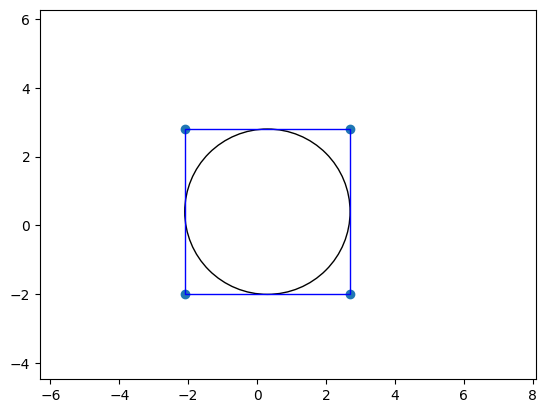

In [3]:
ins = Instance((0.3, 0.4), 2.4, (1.1, 1.8))

rectangle_tangent_lines = [
    Line([ins.circle_center[0] + ins.circle_radius, ins.circle_center[1]],
          [0, 1]),
    Line([ins.circle_center[0] - ins.circle_radius, ins.circle_center[1]],
          [0, 1]),
    Line([ins.circle_center[0], ins.circle_center[1] + ins.circle_radius],
          [1, 0]),
    Line([ins.circle_center[0], ins.circle_center[1] - ins.circle_radius],
          [1, 0])
]

tangent_lines = []

plt.figure()
plt.ion()
clear_plot()
draw_instance_circle(ins)
draw_solution_space(ins, rectangle_tangent_lines + tangent_lines)
set_plot_limits(ins)
plt.draw()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-21


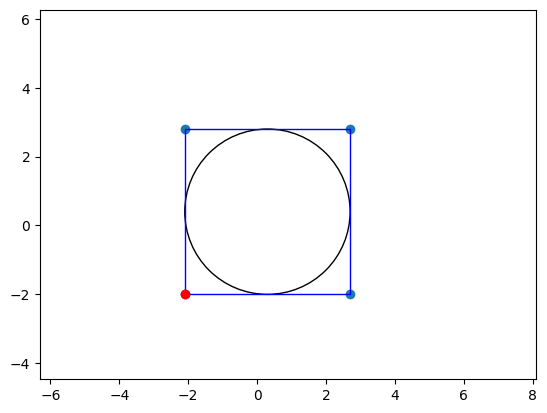

In [4]:
clear_plot()
draw_instance_circle(ins)
draw_solution_space(ins, rectangle_tangent_lines + tangent_lines)
set_plot_limits(ins)
solution = solve_model(ins, rectangle_tangent_lines, tangent_lines)
if is_solution_ok(ins, solution):
    draw_current_solution(ins, solution, 'g')
    plt.draw()
else:
    draw_current_solution(ins, solution, 'r')
plt.draw()

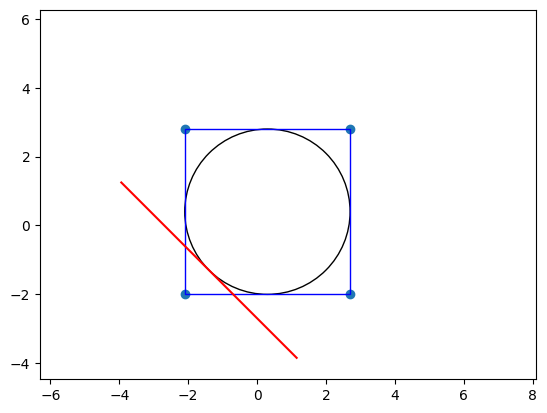

In [5]:
new_tangent_line = Line.create_tangent_line(ins, solution)

clear_plot()
draw_instance_circle(ins)
draw_solution_space(ins, rectangle_tangent_lines + tangent_lines)
draw_circle_tangent_lines(ins, [new_tangent_line])
set_plot_limits(ins)
plt.draw()
tangent_lines.append(new_tangent_line)

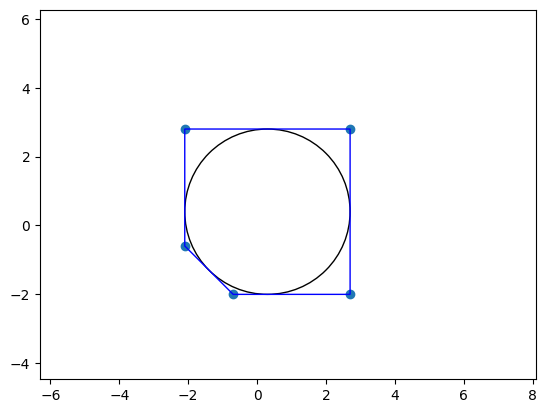

In [6]:
clear_plot()
draw_instance_circle(ins)
draw_solution_space(ins, rectangle_tangent_lines + tangent_lines)
set_plot_limits(ins)
plt.draw()

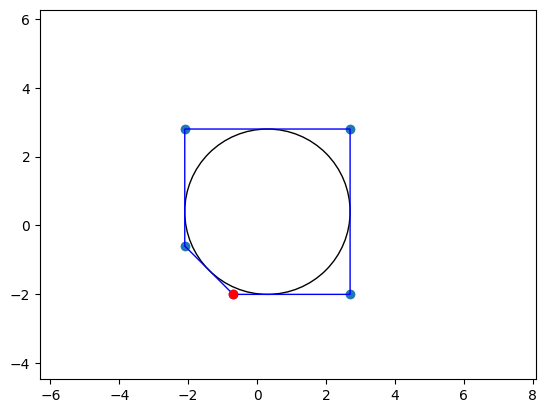

In [7]:
clear_plot()
draw_instance_circle(ins)
draw_solution_space(ins, rectangle_tangent_lines + tangent_lines)
set_plot_limits(ins)
solution = solve_model(ins, rectangle_tangent_lines, tangent_lines)
if is_solution_ok(ins, solution):
    draw_current_solution(ins, solution, 'g')
    plt.draw()
else:
    draw_current_solution(ins, solution, 'r')
plt.draw()

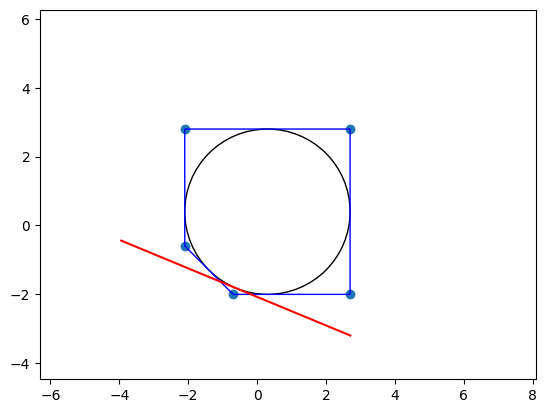

In [8]:
new_tangent_line = Line.create_tangent_line(ins, solution)

clear_plot()
draw_instance_circle(ins)
draw_solution_space(ins, rectangle_tangent_lines + tangent_lines)
draw_circle_tangent_lines(ins, [new_tangent_line])
set_plot_limits(ins)
plt.draw()
tangent_lines.append(new_tangent_line)

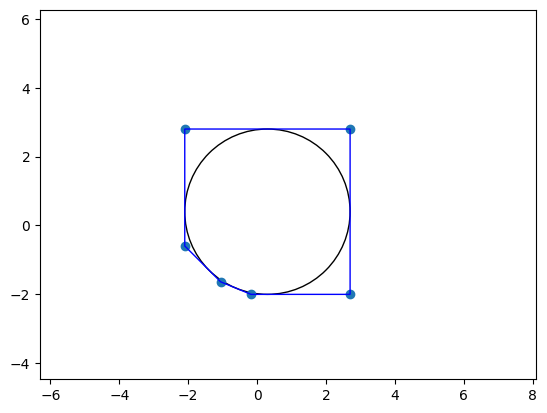

In [9]:
clear_plot()
draw_instance_circle(ins)
draw_solution_space(ins, rectangle_tangent_lines + tangent_lines)
set_plot_limits(ins)
plt.draw()

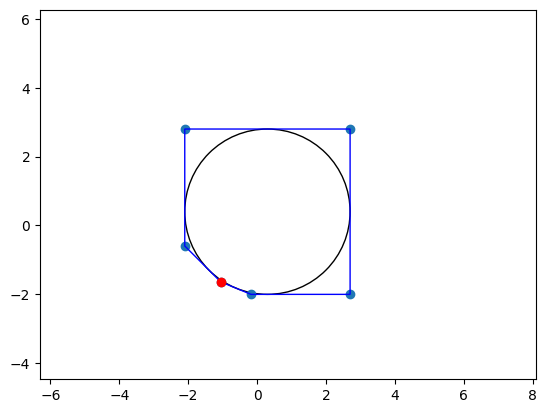

In [10]:
clear_plot()
draw_instance_circle(ins)
draw_solution_space(ins, rectangle_tangent_lines + tangent_lines)
set_plot_limits(ins)
solution = solve_model(ins, rectangle_tangent_lines, tangent_lines)
if is_solution_ok(ins, solution):
    draw_current_solution(ins, solution, 'g')
    plt.draw()
else:
    draw_current_solution(ins, solution, 'r')
plt.draw()

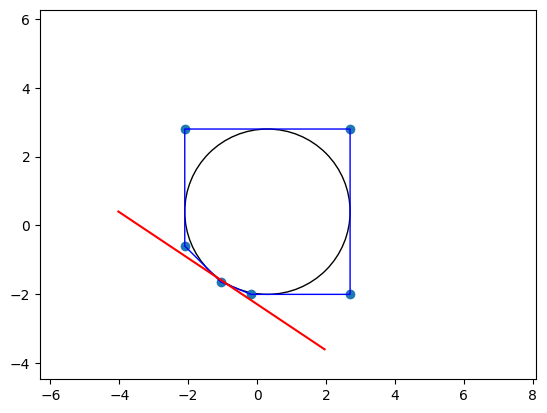

In [11]:
new_tangent_line = Line.create_tangent_line(ins, solution)

clear_plot()
draw_instance_circle(ins)
draw_solution_space(ins, rectangle_tangent_lines + tangent_lines)
draw_circle_tangent_lines(ins, [new_tangent_line])
set_plot_limits(ins)
plt.draw()
tangent_lines.append(new_tangent_line)

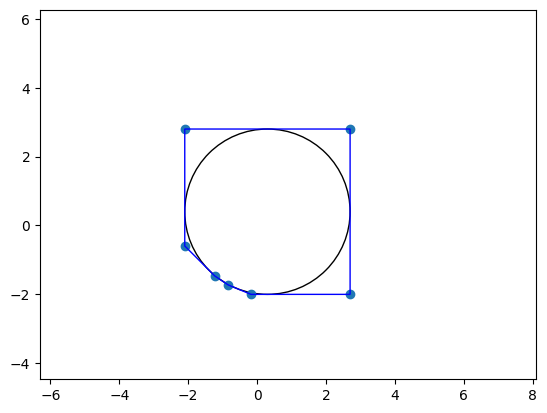

In [12]:
clear_plot()
draw_instance_circle(ins)
draw_solution_space(ins, rectangle_tangent_lines + tangent_lines)
set_plot_limits(ins)
plt.draw()

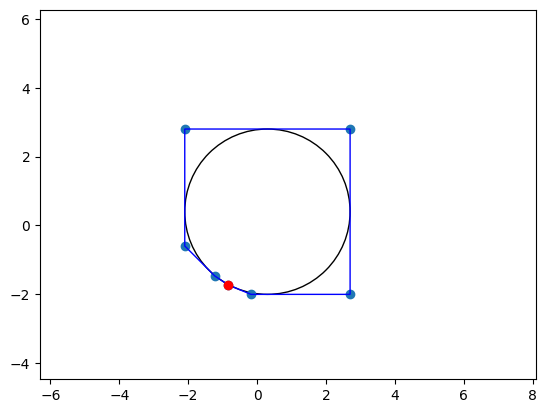

In [13]:
clear_plot()
draw_instance_circle(ins)
draw_solution_space(ins, rectangle_tangent_lines + tangent_lines)
set_plot_limits(ins)
solution = solve_model(ins, rectangle_tangent_lines, tangent_lines)
if is_solution_ok(ins, solution):
    draw_current_solution(ins, solution, 'g')
    plt.draw()
else:
    draw_current_solution(ins, solution, 'r')
plt.draw()